In [1]:
import tensorflow as tf

2022-03-02 09:32:23.968882: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


2022-03-02 09:32:26.841384: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-02 09:32:26.855731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-02 09:32:26.935887: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-02 09:32:26.936482: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1070 computeCapability: 6.1
coreClock: 1.7845GHz coreCount: 15 deviceMemorySize: 7.93GiB deviceMemoryBandwidth: 2

In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce GTX 1070


In [4]:
# import the training data into df 
import pandas as pd 

df = pd.read_csv('CSVFiles/training-data.csv')
df.head()

,Unnamed: 0,Date,text,Sentiment
0,0,2019-05-27,@tippin_me @karozagorus I give 5 satoshis to e...,Positive
1,1,2019-05-27,@hitbtc @bkargili Attention hit btc does scam ...,Positive
2,2,2019-05-27,BTC(ビットコイン)が95万円超えてますやん… https://t.co/uzXGkzKDcI,Positive
3,3,2019-05-27,@CryptoGainz1 Yep https://t.co/TrpbxApU3H,Positive
4,4,2019-05-27,"@Kexkey @hodlwallet We’ll miss you, but we won...",Positive


In [5]:
import matplotlib.pyplot as plt 
import seaborn as sns 

Text(0.5, 0, 'Sentiment Score')

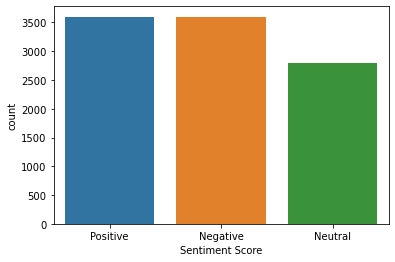

In [6]:
sns.countplot(x=df.Sentiment)
plt.xlabel('Sentiment Score')

In [7]:
# install hugging face library to use their transformers package 
!pip install huggingface

In [8]:
print('Number of training sentences: {:,}\n'.format(df.shape[0])) # we have 10,006 total sentences 

Number of training sentences: 10,006



In [9]:
df = df.replace({'Sentiment': {'Negative':0, 'Neutral':1, 'Positive':2}})  
df.sample(10)

,Unnamed: 0,Date,text,Sentiment
9996,9990,NaN,Hackers delight: 2017 bitcoin mania led to exp...,1.0
1979,1979,2019-05-27,O valor do Bitcoin caiu :( - R$34000,2.0
2719,2719,2019-05-27,Another hour! It's #WEALTHGENERATION TIME get ...,2.0
7077,7077,2019-05-21,VanEck Bitcoin (BTC) ETF Verdict Delayed By Th...,0.0
3298,3298,2019-05-27,Worrying about monopolies in tech is not produ...,2.0
580,580,2019-05-27,Moonday Mornings: Microsoft helped Louis Vuitt...,2.0
3570,3570,2019-05-27,Lol Kevin on CNBC crack me up . Calling bitcoi...,2.0
9820,9814,NaN,https://t.co/dNWfSgjtJ2 #PDATA #Opirium #ether...,1.0
6395,6395,2019-05-21,@tylerwinklevoss As long as the #Bitcoin commu...,0.0
3008,3008,2019-05-27,#ooobtc #obx #IEO #exchange #crypto #bitcoin #...,2.0


In [10]:
# !pip install transformers
# now we want to format our data so that VERT can use it for training 
from transformers import BertTokenizer 

# load the BERT tokenizer 
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

In [11]:
# some regex to clean the data before passing it to BERT tokenizer  
import re 
df = df.replace(to_replace='https?:\/\/\S+', value='', regex=True) # remove https urls 
df = df.replace(to_replace="www\.[a-z]?\.?(com)+|[a-z]+\.(com)", value='', regex=True) # remove www urls 
df = df.replace(to_replace="\[video\]", value='', regex=True) # remove videos that got replaced with [video]
df = df.replace(to_replace='{link}', value='', regex=True) # remove links 
df = df.replace(to_replace='&[a-z]+;', value='', regex=True) # remove HTML embedded characters
df = df.replace(to_replace='@[^ ]+', value='', regex=True) # remove @usernames 

# some sample output 
tweets = df.text.values 
labels = df.Sentiment.values 
import numpy as np
labels = np.array(labels)

print(' Original: ', tweets[0])
print('Tokenized: ', tokenizer.tokenize(tweets[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:    I give 5 satoshis to everyone for free and without any conditions. 

So anyone can instantly start using and learning Bitcoin without any initial investment.🎉

#Bitcoin #MassAdoption #LightningNetwork
Tokenized:  ['i', 'give', '5', 'sato', '##shi', '##s', 'to', 'everyone', 'for', 'free', 'and', 'without', 'any', 'conditions', '.', 'so', 'anyone', 'can', 'instantly', 'start', 'using', 'and', 'learning', 'bit', '##co', '##in', 'without', 'any', 'initial', 'investment', '.', '[UNK]', '#', 'bit', '##co', '##in', '#', 'mass', '##ado', '##ption', '#', 'lightning', '##net', '##work']
Token IDs:  [1045, 2507, 1019, 20251, 6182, 2015, 2000, 3071, 2005, 2489, 1998, 2302, 2151, 3785, 1012, 2061, 3087, 2064, 6880, 2707, 2478, 1998, 4083, 2978, 3597, 2378, 2302, 2151, 3988, 5211, 1012, 100, 1001, 2978, 3597, 2378, 1001, 3742, 9365, 16790, 1001, 7407, 7159, 6198]


In [12]:
df = df.drop(['Unnamed: 0'],axis=1)
df

,Date,text,Sentiment
0,2019-05-27,I give 5 satoshis to everyone for free and w...,2.0
1,2019-05-27,Attention hit btc does scam with me and not ...,2.0
2,2019-05-27,BTC(ビットコイン)が95万円超えてますやん…,2.0
3,2019-05-27,Yep,2.0
4,2019-05-27,"We’ll miss you, but we won’t let our ideolog...",2.0
...,...,...,...
10001,NaN,Yes - the term colored coin comes from the ...,1.0
10002,NaN,0 to 50% – Time to Pay Crypto Taxes in the Eur...,1.0
10003,NaN,RT Chinese Exchange Bitasia Now Supports 0-Co...,1.0
10004,NaN,Nice💰,1.0


In [13]:
max_len = 0 

for i in range(len(tweets)):
    # tokenize the text and add `[CLS]` and `[SEP]` tokens 
    input_ids = tokenizer.encode(str(tweets[i]), add_special_tokens=True)
    
    #update max sentence length
    max_len = max(max_len, len(input_ids))
    
print('max sentence length: ', max_len)

max sentence length:  203


In [14]:
# we will set max_len to 235 
# now we can perform tokenization 
input_ids = [] 
attention_masks = [] 

for i in range(len(tweets)):
    encoded_dict = tokenizer.encode_plus(
                        str(tweets[i]),                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    # add encoded sentence to list 
    input_ids.append(encoded_dict['input_ids'])
    # add attention masks to list 
    attention_masks.append(encoded_dict['attention_mask'])
    
#convert the lists into tensors 
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/phil81/anaconda3/envs/tf-gpu/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2251: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:    I give 5 satoshis to everyone for free and without any conditions. 

So anyone can instantly start using and learning Bitcoin without any initial investment.🎉

#Bitcoin #MassAdoption #LightningNetwork
Token IDs: tensor([  101,  1045,  2507,  1019, 20251,  6182,  2015,  2000,  3071,  2005,
         2489,  1998,  2302,  2151,  3785,  1012,  2061,  3087,  2064,  6880,
         2707,  2478,  1998,  4083,  2978,  3597,  2378,  2302,  2151,  3988,
         5211,  1012,   100,  1001,  2978,  3597,  2378,  1001,  3742,  9365,
        16790,  1001,  7407,  7159,  6198,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [15]:
# we will not divide our training data into training and validation sets (90/10)
from torch.utils.data import TensorDataset, random_split 

In [16]:
# combine training inputs into a training dataset 
dataset = TensorDataset(input_ids, attention_masks, labels)

training_size = int(0.9*len(dataset))
validation_size = len(dataset) - training_size

# Divide the dataset by randomly selecting samples.
training_dataset, validation_dataset = random_split(dataset, [training_size, validation_size])

print('{:>5,} training samples'.format(training_size))
print('{:>5,} validation samples'.format(validation_size))

9,005 training samples
1,001 validation samples


In [19]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            training_dataset,  # The training samples.
            sampler = RandomSampler(training_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            validation_dataset, # The validation samples.
            sampler = SequentialSampler(validation_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [20]:
# Now that we have properly formatted our input data, we are going to fine-tune the BERT model 
# huggincgface pytorch has many interfaces designed for NLP tasks (BertForSequenceClassification)
from transformers import BertForSequenceClassification, AdamW, BertConfig 